In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 2
NUM_CLASSES = 4

# Defining the model (DeepLabV3+)

In [ ]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 1))
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )

    for layer in resnet50.layers:
      layer.trainable = True

    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

import skimage.io as io
from skimage import transform
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif'
train_images = io.imread(stack_path)

resized_train_images = []
for image in train_images[:300]:
    image = tf.keras.applications.resnet50.preprocess_input(image)
    resized_train_images.append(image)

train_images = np.array(resized_train_images)

print("Shape of the TIFF stack:", train_images.shape)

Shape of the TIFF stack: (300, 128, 128)


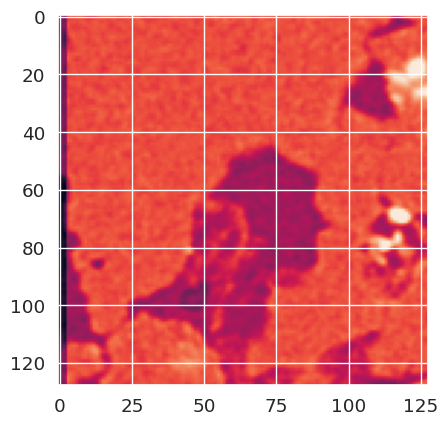

In [ ]:
plt.imshow(train_images[0])

In [ ]:
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif'
train_masks = io.imread(stack_path)

resized_train_masks = []
for image in train_masks[:300]:
    resized_train_masks.append(image)
train_masks = np.array(resized_train_masks)

print("Shape of the TIFF stack:", train_masks.shape)

Shape of the TIFF stack: (300, 128, 128)


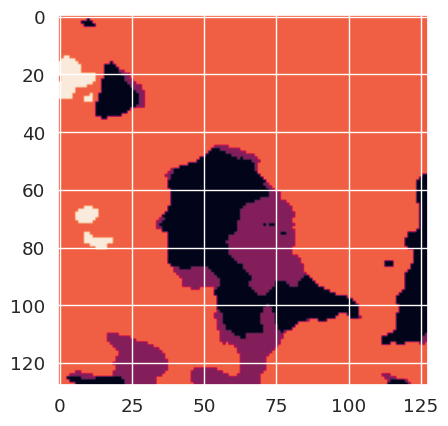

In [ ]:
plt.imshow(train_masks[0])

In [ ]:
print(np.unique(train_masks[0]))

[1 2 3 4]


(128, 128)


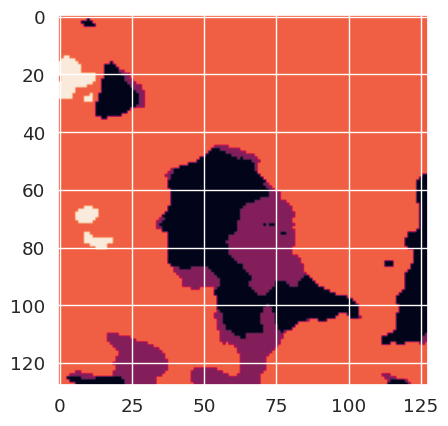

In [ ]:
plt.imshow(train_masks[0])
print(train_masks[0].shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
print(n, h, w)
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

300 128 128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [ ]:
print(train_images.shape)

train_images.shape

(300, 128, 128)


(300, 128, 128)

In [ ]:
print("Before: ", train_images)
#train_images = normalize(train_images, axis=1)
print("After: ", train_images)

Before:  [[[ 3.6060997e+01  2.1221001e+01 -7.6800003e+00 ...  1.2700000e+02
    1.2400000e+02  1.1700000e+02]
  [ 2.4060997e+01  8.2210007e+00 -9.6800003e+00 ...  1.2300000e+02
    1.2300000e+02  1.2200000e+02]
  [ 7.0609970e+00  4.2210007e+00  1.3199997e+00 ...  1.2200000e+02
    1.2400000e+02  1.2400000e+02]
  ...
  [ 1.7060997e+01  1.8221001e+01  3.3320000e+01 ...  5.5000000e+01
    7.1000000e+01  9.2000000e+01]
  [ 1.2060997e+01  1.0221001e+01  2.0320000e+01 ...  9.1000000e+01
    1.1500000e+02  1.3100000e+02]
  [ 1.6060997e+01  7.2210007e+00  1.1320000e+01 ...  1.3800000e+02
    1.4000000e+02  1.3500000e+02]]

 [[-2.5939003e+01 -5.7778999e+01 -6.7680000e+01 ...  4.4000000e+01
    3.0000000e+01  2.7000000e+01]
  [-4.1939003e+01 -6.8778999e+01 -7.9680000e+01 ...  4.8000000e+01
    3.5000000e+01  3.1000000e+01]
  [-5.4939003e+01 -7.9778999e+01 -9.5680000e+01 ...  5.5000000e+01
    3.7000000e+01  3.8000000e+01]
  ...
  [ 1.8060997e+01  1.4221001e+01  8.3199997e+00 ...  1.1800000e+02
 

In [ ]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(300, 128, 128, 1)


In [ ]:
np.unique(train_masks_input[0])

array([0, 1, 2, 3])

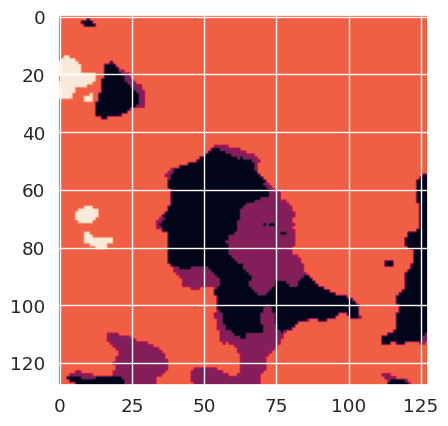

In [ ]:
plt.imshow(train_masks_input[0])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(270, 128, 128)
(30, 128, 128)
(270, 128, 128, 1)
(30, 128, 128, 1)


In [ ]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [ ]:
# Categorical encoding
from keras.utils import to_categorical
#n_classes=4
#train_masks_cat = to_categorical(y_train, num_classes=n_classes)
#y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
#test_masks_cat = to_categorical(y_test, num_classes=n_classes)
#y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
# Class weights to handle class imbalance
class_labels = np.unique(train_masks_reshaped_encoded)
class_counts = [np.sum(train_masks_reshaped_encoded == label) for label in class_labels]
total_samples = len(train_masks_reshaped_encoded)
class_weights = total_samples / (len(class_labels) * np.array(class_counts))

# Print the calculated class weights
print("Class Weights:", class_weights)

Class Weights: [1.92494772 2.88047033 0.33074303 9.10377324]


In [ ]:
tx = to_categorical(y_train, 4)
tx

array([[[[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        ...,

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
 

In [ ]:


print(X_train.shape)

(270, 128, 128)


In [ ]:
print(X_train[0].shape)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = DeeplabV3Plus(128, 4)
optimizer=keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

(128, 128)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 1)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                             

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/20
9/9 [==============================] - 35s 335ms/step - loss: 1.0146 - accuracy: 0.7065 - val_loss: 1353.6310 - val_accuracy: 0.0360
Epoch 2/20
9/9 [==============================] - 2s 197ms/step - loss: 0.7622 - accuracy: 0.7566 - val_loss: 1398.7151 - val_accuracy: 0.0380
Epoch 3/20
9/9 [==============================] - 2s 197ms/step - loss: 0.6826 - accuracy: 0.7652 - val_loss: 316.8974 - val_accuracy: 0.0370
Epoch 4/20
9/9 [==============================] - 2s 199ms/step - loss: 0.6082 - accuracy: 0.7839 - val_loss: 69.3367 - val_accuracy: 0.0376
Epoch 5/20
9/9 [==============================] - 2s 200ms/step - loss: 0.5501 - accuracy: 0.7987 - val_loss: 4.3768 - val_accuracy: 0.6155
Epoch 6/20
9/9 [==============================] - 2s 205ms/step - loss: 0.5100 - accuracy: 0.8099 - val_loss: 2.5752 - val_accuracy: 0.4497
Epoch 7/20
9/9 [==============================] - 2s 205ms/step - loss: 0.4628 - accuracy: 0.8258 - val_loss: 1.4200 - val_accuracy: 0.7269
Epoch 8/20

In [ ]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 120ms/step - loss: 1.1125 - accuracy: 0.7661
Accuracy is =  76.60990357398987 %


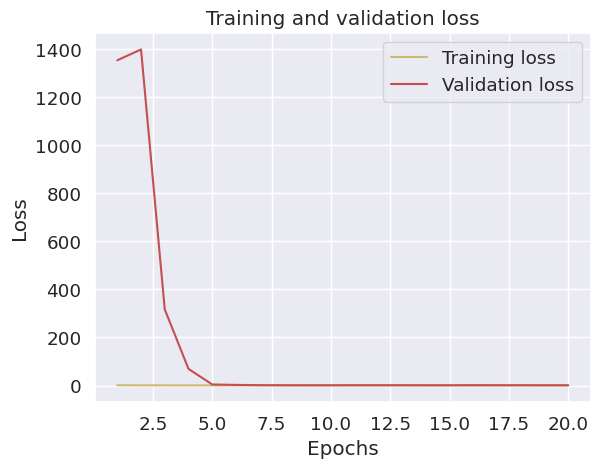

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

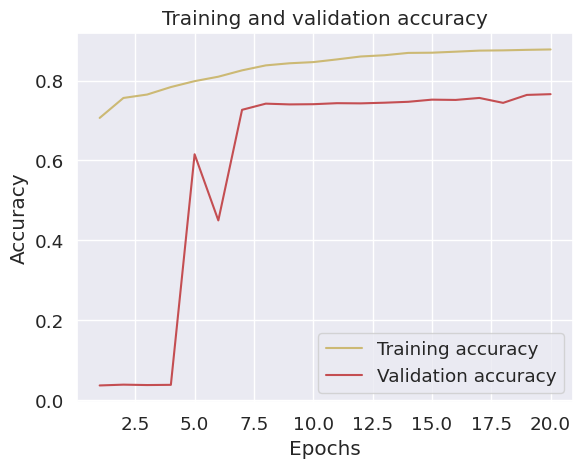

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(X_test[3])
print(X_test[0].shape)

[[ 13.060997   -1.7789993 -13.68      ... 255.        255.
  255.       ]
 [  8.060997   -1.7789993  -9.68      ... 255.        255.
  255.       ]
 [ 16.060997    3.2210007  -1.6800003 ... 255.        255.
  255.       ]
 ...
 [151.061     138.22101   131.32      ... 111.        132.
  137.       ]
 [151.061     138.22101   131.32      ...  83.        108.
  126.       ]
 [151.061     138.22101   131.32      ...  49.         69.
   97.       ]]
(128, 128)


9/9 [==============================] - 1s 65ms/step


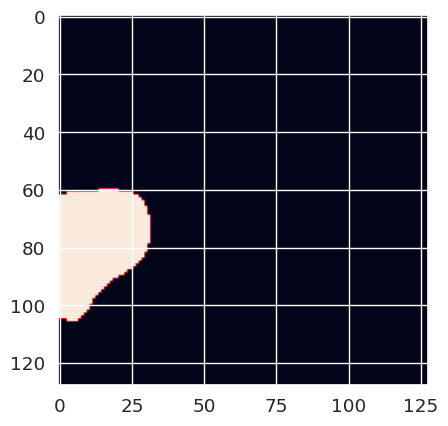

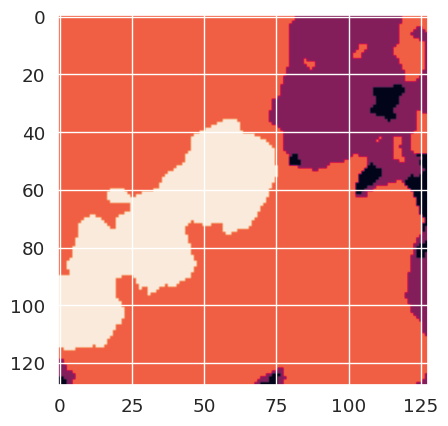

In [ ]:
# Visualizing model output
# prediction on training set
#print(repeat_channels(X_test[3]))
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=-1)
plt.imshow(y_pred_argmax[0])
plt.show()

plt.imshow(y_train[0])
plt.show()

In [ ]:
from scipy.ndimage import rotate
def apply_random_rotation(image, mask):
    angle = np.random.uniform(0, 180)
    rotated_image = rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        rotated_channel = rotate(mask[..., channel], angle, reshape=False, mode='reflect')
        rotated_mask[..., channel] = (rotated_channel > 0.5).astype(np.float32)
    return rotated_image, rotated_mask

In [ ]:
def apply_horizontal_flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.fliplr(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [ ]:
def apply_vertical_flip(image, mask):
    flipped_image = np.flipud(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.flipud(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [ ]:
augmented_image, augmented_mask = apply_vertical_flip(X_train[0], y_train[0])
print("Image Shape: ", augmented_image.shape)
print("Mask Shape: ", augmented_mask.shape)

Image Shape:  (128, 128)
Mask Shape:  (128, 128, 1)


In [ ]:
augmented_images = []
augmented_masks = []
for i in range(X_train.shape[0]):
    rot_img, rot_mask = apply_random_rotation(X_train[i], y_train[i])
    h_flip_img, h_flip_mask = apply_horizontal_flip(X_train[i], y_train[i])
    v_flip_img, v_flip_mask = apply_vertical_flip(X_train[i], y_train[i])

    augmented_images.append(rot_img)
    augmented_images.append(h_flip_img)
    augmented_images.append(v_flip_img)

    augmented_masks.append(rot_mask)
    augmented_masks.append(h_flip_mask)
    augmented_masks.append(v_flip_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
print("Aug Image Shape: ", augmented_images.shape)
print("Aug Mask Shape: ", augmented_masks.shape)

Aug Image Shape:  (810, 128, 128)
Aug Mask Shape:  (810, 128, 128, 1)


In [ ]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, augmented_masks), axis = 0)
print("Full Aug Image Shape: ", X_train_aug.shape)
print("Full Aug Mask Shape: ", y_train_aug.shape)

Full Aug Image Shape:  (1080, 128, 128)
Full Aug Mask Shape:  (1080, 128, 128, 1)


In [ ]:
# Increasing the number of epochs from 50 ==> 100
# Using the augmented dataset of images and masks
# Augmented version causes loss= nan, so not using it.
history_aug = model.fit(X_train_aug, y_train_aug,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/20
34/34 [==============================] - 7s 204ms/step - loss: 0.6674 - accuracy: 0.7740 - val_loss: 942.4417 - val_accuracy: 0.7404
Epoch 2/20
34/34 [==============================] - 7s 205ms/step - loss: 0.7314 - accuracy: 0.7405 - val_loss: 51.0539 - val_accuracy: 0.7313
Epoch 3/20
34/34 [==============================] - 7s 205ms/step - loss: 0.6077 - accuracy: 0.7817 - val_loss: 2.7746 - val_accuracy: 0.7173
Epoch 4/20
34/34 [==============================] - 7s 207ms/step - loss: 0.5324 - accuracy: 0.8085 - val_loss: 0.8162 - val_accuracy: 0.7676
Epoch 5/20
34/34 [==============================] - 7s 206ms/step - loss: 0.4702 - accuracy: 0.8286 - val_loss: 0.8503 - val_accuracy: 0.7477
Epoch 6/20
34/34 [==============================] - 7s 210ms/step - loss: 0.4446 - accuracy: 0.8379 - val_loss: 0.5653 - val_accuracy: 0.8044
Epoch 7/20
34/34 [==============================] - 7s 208ms/step - loss: 0.4070 - accuracy: 0.8496 - val_loss: 0.4458 - val_accuracy: 0.8437
Epo

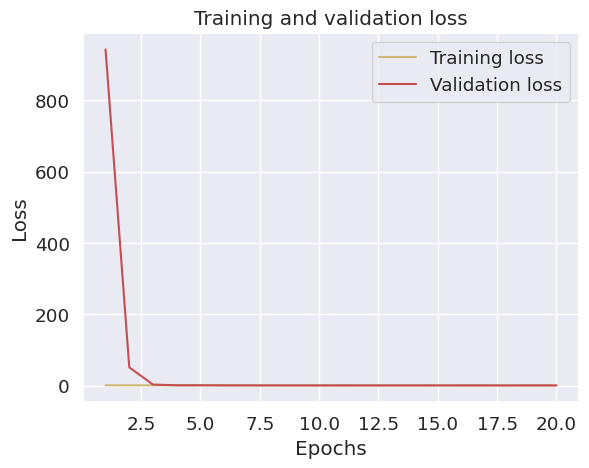

In [ ]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

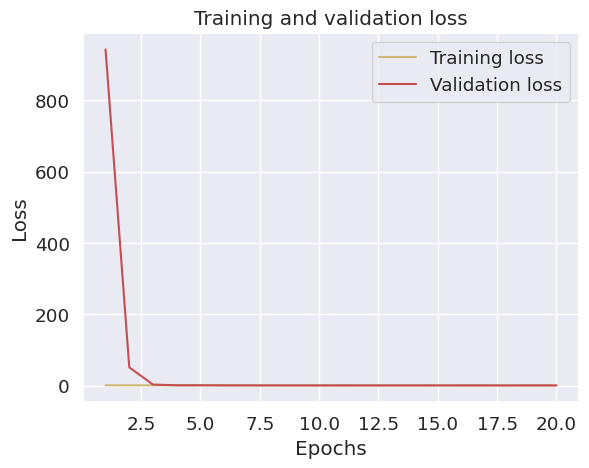

In [ ]:
accuracy = history_aug.history['accuracy']
val_accuracy = history_aug.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

### Comparitive analysis of evaluation metrics of the models on the sandstone dataset

In [ ]:
# prediction on training set
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 2s 2s/step


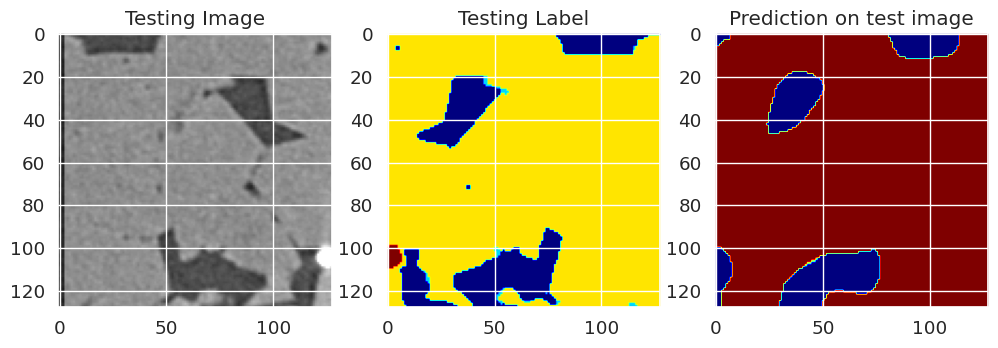

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
print("true: ", y_test.shape)
print("pred: ", y_pred.shape)

true:  (30, 128, 128, 1)
pred:  (30, 128, 128, 4)


In [ ]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

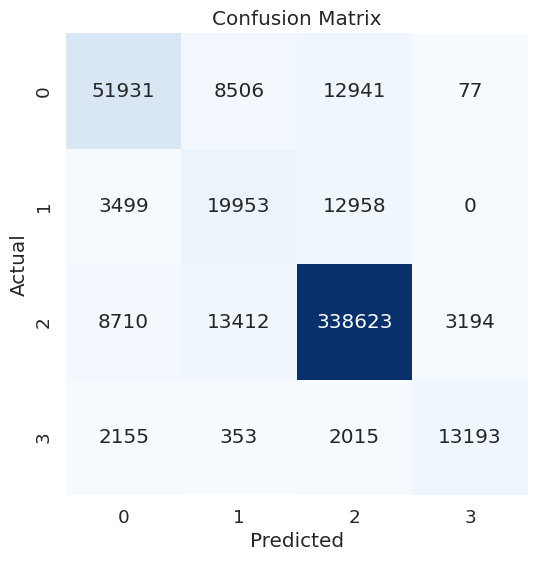

In [ ]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_test, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 86.2%


In [ ]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_test, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

Class 0 precision: 78%
Class 1 precision: 47%
Class 2 precision: 92%
Class 3 precision: 80%


In [ ]:
# recall
def classwise_recall(y_test, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 71%
Class 1 precision: 55%
Class 2 precision: 93%
Class 3 precision: 74%


In [ ]:
# f1-score
def classwise_f1_score(y_test, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 71%
Class 1 precision: 55%
Class 2 precision: 93%
Class 3 precision: 74%


In [ ]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6060379


In [ ]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[5.19310e+04 8.50600e+03 1.29410e+04 7.70000e+01]
 [3.49900e+03 1.99530e+04 1.29580e+04 0.00000e+00]
 [8.71000e+03 1.34120e+04 3.38623e+05 3.19400e+03]
 [2.15500e+03 3.53000e+02 2.01500e+03 1.31930e+04]]
IoU for class1 is:  0.59134126
IoU for class2 is:  0.3400249
IoU for class3 is:  0.8641583
IoU for class4 is:  0.62862724


Training Set

In [ ]:
# prediction on training set
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)

9/9 [==============================] - 1s 64ms/step


1/1 [==============================] - 0s 38ms/step


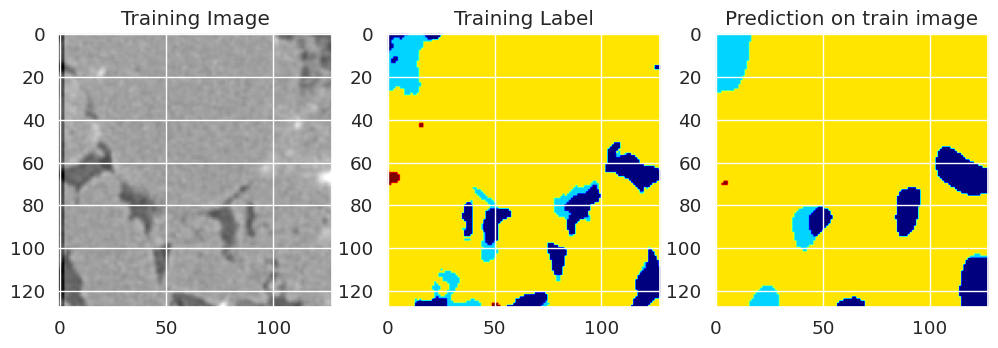

In [ ]:
import random
train_img_number = random.randint(0, len(X_train))
train_img = X_train[train_img_number]
ground_truth=y_train[train_img_number]
train_img_norm=train_img[:,:][:,:,None]
train_img_input=np.expand_dims(train_img_norm, 0)
prediction = (model.predict(train_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(train_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Training Label')
plt.imshow(ground_truth[:,:], cmap='jet')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
print("true: ", y_train.shape)
print("pred: ", y_pred.shape)

true:  (270, 128, 128, 1)
pred:  (270, 128, 128, 4)


In [ ]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

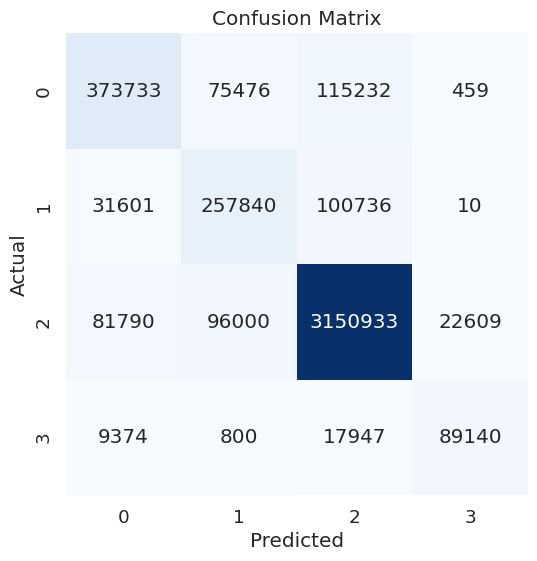

In [ ]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_train.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_train, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 87.52%


In [ ]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_train, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

Class 0 precision: 75%
Class 1 precision: 60%
Class 2 precision: 93%
Class 3 precision: 79%


In [ ]:
# recall
def classwise_recall(y_train, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 66%
Class 1 precision: 66%
Class 2 precision: 94%
Class 3 precision: 76%


In [ ]:
# f1-score
def classwise_f1_score(y_train, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 66%
Class 1 precision: 66%
Class 2 precision: 94%
Class 3 precision: 76%


In [ ]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_train[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.62898266


In [ ]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[3.737330e+05 7.547600e+04 1.152320e+05 4.590000e+02]
 [3.160100e+04 2.578400e+05 1.007360e+05 1.000000e+01]
 [8.179000e+04 9.600000e+04 3.150933e+06 2.260900e+04]
 [9.374000e+03 8.000000e+02 1.794700e+04 8.914000e+04]]
IoU for class1 is:  0.5434812
IoU for class2 is:  0.45841238
IoU for class3 is:  0.8788608
IoU for class4 is:  0.63517624
